# 0.0 Imports


In [128]:
import pandas as pd
import numpy as np
import inflection

import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as pg
import pickle
import random
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn import linear_model as lm
from sklearn import tree as tr
from sklearn import preprocessing as pp
from sklearn import ensemble as en
from sklearn import neighbors as ng
from boruta import BorutaPy
import xgboost as xgb

from flask import Flask, request, Response
import json
import requests

import scikitplot as sktplt
from imblearn import under_sampling as us

## 0.1 Helper Functions

In [129]:
def precision_at_k(X_test, y_test, yhat, k=2000):

    data = X_test.copy()
    data['response'] = y_test.copy()

 
    data['score'] = yhat[:,1].tolist()
    data = data.sort_values('score', ascending=False)


    data = data.reset_index(drop=True)
    data['ranking'] = data.index +1 

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(X_test, y_test,yhat, k=2000):

    data = X_test.copy()
    data['response'] = y_test.copy()

    data['score'] = yhat[:,1].tolist()
    data = data.sort_values('score', ascending=False)


    data = data.reset_index(drop=True)
    data['ranking'] = data.index +1 

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']


def model_result(model_name,X_test,y_test, yhat,k=2000):
    name = model_name
    precision = precision_at_k(X_test,y_test,yhat,k)
    recall = recall_at_k(X_test, y_test,yhat,k)


    return pd.DataFrame({'Model name': name, 'Precision at k': precision, 'Recall at k': recall}, index=[0])


def cross_validation(model_name,model,x_train, y_train, kfold=5):

    skf = ms.StratifiedKFold(n_splits=kfold, shuffle=True, random_state=42)

    precision_list = []
    recall_list = []

    for train_index, val_index in skf.split(x_train,y_train):
        x_train_cv, x_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        #model definidtion
        m = model.fit(x_train_cv, y_train_cv)
        yhat_cv = m.predict_proba(x_val_cv)
        ml_cv_result = model_result(model_name, x_val_cv, y_val_cv, yhat_cv, k=2000)
        precision_list.append(ml_cv_result['Precision at k'])
        recall_list.append(ml_cv_result['Recall at k'])
        

        metric = pd.DataFrame({'Model name': model_name, 'Precision at k': np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str) , 
                               'Recall at k': np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)}, index=[0])

    return metric
    

## 0.2 Load Data

In [130]:
data_train_raw = pd.read_csv('../inputs/train.csv')

In [316]:
data_train_raw

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


## 0.3 Rename Columns

In [131]:
#old columns
cols_old = list(data_train_raw.columns)
#creating function
rename_columns = lambda x: inflection.underscore(x)
#new columns
cols_new = list(map(rename_columns, cols_old))
#renaming columns 
data_train_raw.columns = cols_new

## 0.3 Split dataset

In [132]:
X = data_train_raw.drop('response', axis=1)
y = data_train_raw[['response']]


In [247]:
X_train, X_test, y_train, y_test = ms.train_test_split(X,y, test_size=0.2, random_state=42)

In [134]:
#train dataset
df_train = pd.concat([X_train, y_train], axis=1)

#test dataset
df_test = pd.concat([X_test, y_test], axis=1)

# 1.0 Data Description

In [135]:
df1 = df_train.copy()


- 'id': 	'Unique ID for the customer',
- 'Gender': 	'Gender of the customer',
- 'Age': 	'Age of the customer',
- 'Driving_License': 	'0 : Customer does not have DL, 1 : Customer already has DL',
- 'Region_Code': 	'Unique code for the region of the customer',
- 'Previously_Insured': 	'1 : Customer already has Vehicle Insurance, 0 : Customer doesnt have Vehicle Insurance',
- 'Vehicle_Age': 	'Age of the Vehicle',
- 'Vehicle_Damage': 	'1 : Customer got his/her vehicle damaged in the past. 0 : Customer didnt get his/her vehicle damaged in the past.',
- 'Annual_Premium': 	'The amount customer needs to pay as premium in the year',
- 'Policy_Sales_Channel': 	'Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.',
- 'Vintage': 	'Number of Days, Customer has been associated with the company',
- 'Response': 	'1 : Customer is interested, 0 : Customer is not interested'}



## 1.1 Data amount

In [136]:
print('Quantidade de linhas: {}'.format(df1.shape[0]))
print('Quantidade de colunas: {}'.format(df1.shape[1]))


Quantidade de linhas: 304887
Quantidade de colunas: 12


## 1.2 Data Types

In [137]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NaN

In [138]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Descriptive Statistical

In [139]:
numerical_features = df1.select_dtypes(include=['int64', 'float64'])
categorical_features = df1.select_dtypes(exclude=['int64','float64'])

### 1.4.1 Numerical Features

In [140]:
#Têndencia central
t01 = pd.DataFrame(numerical_features.apply(np.mean)).T
t02 = pd.DataFrame(numerical_features.apply(np.median)).T
#Dispersão dos dados
d01 = pd.DataFrame(numerical_features.apply(np.min)).T
d02 = pd.DataFrame(numerical_features.apply(np.max)).T
d03 = pd.DataFrame(numerical_features.apply(lambda x: x.max() - x.min())).T
d04 = pd.DataFrame(numerical_features.apply(np.std)).T
d05 = pd.DataFrame(numerical_features.apply(lambda x: x.skew())).T
d06 = pd.DataFrame(numerical_features.apply(lambda x: x.kurtosis())).T

m = pd.concat([d01,d02,d03,t01,t02,d04,d05,d06]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skewness','kurtosis']
m


,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,id,1.0,381109.0,381108.0,190594.098072,190639.0,110021.963852,-0.000004,-1.199753
1,age,20.0,85.0,65.0,38.835582,36.0,15.509496,0.670000,-0.570016
2,driving_license,0.0,1.0,1.0,0.997829,1.0,0.046547,-21.390677,455.564047
3,region_code,0.0,52.0,52.0,26.413340,28.0,13.217997,-0.117479,-0.863585
4,previously_insured,0.0,1.0,1.0,0.458373,0.0,0.498264,0.167088,-1.972094
5,annual_premium,2630.0,540165.0,537535.0,30571.851319,31675.0,17254.215590,1.853769,36.695689
6,policy_sales_channel,1.0,163.0,162.0,111.966591,131.0,54.229980,-0.897379,-0.976093
7,vintage,10.0,299.0,289.0,154.272609,154.0,83.642252,0.004656,-1.199888
8,response,0.0,1.0,1.0,0.121970,0.0,0.327251,2.310350,3.337740


### 1.4.2 Categorical Features

In [141]:
categorical_features.nunique()

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0 Feature Engineering

In [142]:
df2 = df1.copy()

## 2.1 Hypothesis Map

1. Índice de Criminalidade da Região influência na contratação do seguro veicular
2. Clientes com maior salário contratariam o seguro veicular
3. Clientes com carros mais novos contratariam o seguro veicular
4. Pessoas mais velhas contratariam o seguro veicular
5. Clientes cujo veículo já sofreu danos contratariam o seguro veicular
6. Somente clientes habilitados contratariam o seguro veicular
7. Clientes mais antigos da seguradora contratariam o seguro veicular
8. Clientes com carros mais novos contratam o seguro veicular

# 3.0 Data Filtering

In [143]:
df3 = df2.copy()

# 4.0 Balanced Data

In [144]:
df41 = df3.copy()
df41.shape

(304887, 12)

In [145]:
df41['response'].value_counts(normalize=True)

response
0    0.87803
1    0.12197
Name: proportion, dtype: float64

In [146]:
df41 = df41.drop('id', axis=1)

In [147]:
df41.sample(5)

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
361931,Female,41,1,21.0,1,1-2 Year,No,18149.0,152.0,118,0
344796,Female,57,1,4.0,0,1-2 Year,Yes,2630.0,124.0,251,0
358755,Female,21,1,15.0,0,< 1 Year,No,27706.0,152.0,174,0
240800,Female,24,1,50.0,1,< 1 Year,No,29645.0,160.0,272,0
126594,Male,59,1,33.0,1,1-2 Year,No,29928.0,26.0,156,0


In [148]:
df41.dtypes

gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [149]:
# encoder categorical variables
ohe = pp.OneHotEncoder()
#numerical
col_num  = df41.select_dtypes(include=['int64', 'float64']).drop('response',axis=1).columns.tolist()
#categorical
col_cat  = df41.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
#encoding

df41_dummy = pd.DataFrame(ohe.fit_transform(df41[col_cat]).toarray(), index=df41.index)

#join numerical and categorical

df42 = pd.concat([df41[col_num], df41_dummy], axis=1)

In [150]:
df42 = df42.rename(str, axis='columns')

## 4.1 Random UnderSampling

In [151]:
#define sampler

undersampling = us.RandomUnderSampler(sampling_strategy='auto', random_state=42)


#apply sampler

x_under, y_under = undersampling.fit_resample(df42, df41['response'])

In [152]:
y_under.value_counts(normalize=True)

response
0    0.5
1    0.5
Name: proportion, dtype: float64

In [153]:
#numerical data
df43 = x_under[col_num]
#categorical data
df44 = x_under.drop(col_num, axis = 1)
#join numerical categorical
df45= pd.DataFrame(ohe.inverse_transform(df44),columns=col_cat, index=df44.index)


df46 = pd.concat([df43, df45], axis=1)
df46['response'] = y_under


In [154]:
df46['response'].value_counts(normalize=True)

response
0    0.5
1    0.5
Name: proportion, dtype: float64

## 4.2 Random OverSampling

# 5.0 Exploratory Data Analysis

In [155]:
df4 = df3.copy()
df4.sample(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
140881,140882,Male,50,1,41.0,0,1-2 Year,Yes,29390.0,26.0,10,1
147336,147337,Male,54,1,28.0,0,1-2 Year,Yes,2630.0,124.0,222,0
298610,298611,Male,24,1,43.0,1,< 1 Year,No,2630.0,152.0,86,0
363916,363917,Female,55,1,0.0,0,1-2 Year,No,2630.0,26.0,297,0
20877,20878,Male,53,1,28.0,0,> 2 Years,Yes,30658.0,124.0,86,0


## 5.1 Univariate Analysis

### 4.1.1 Numerical Features

In [156]:
df4.select_dtypes(include=['int64','float64']).columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'annual_premium', 'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

<Axes: xlabel='age'>

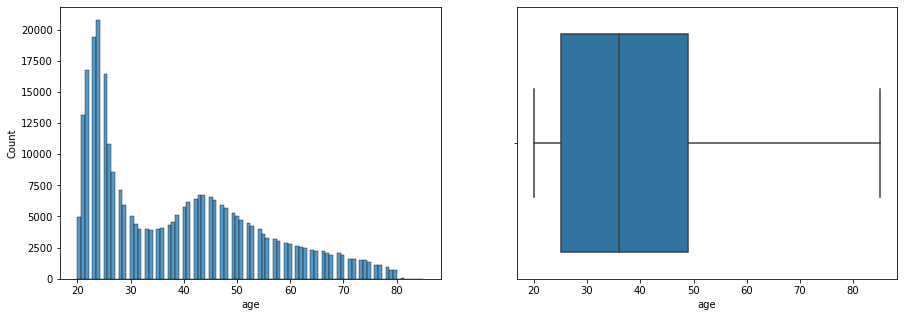

In [157]:
#Age  - Client Age
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='age')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='age')

Como identificado na secção **1.4** a feature Age tem assimetria positiva indicando maior concentração no lado esquerdo do histograma na faixa de idade de 22 e 27 anos aproximadamente. Além de indicar que moda < mediana < média

<Axes: xlabel='annual_premium'>

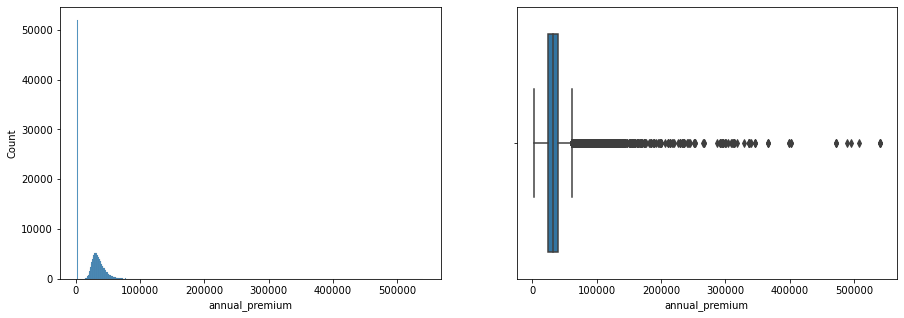

In [158]:
#Annual Premium
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='annual_premium')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='annual_premium')

<Axes: xlabel='vintage'>

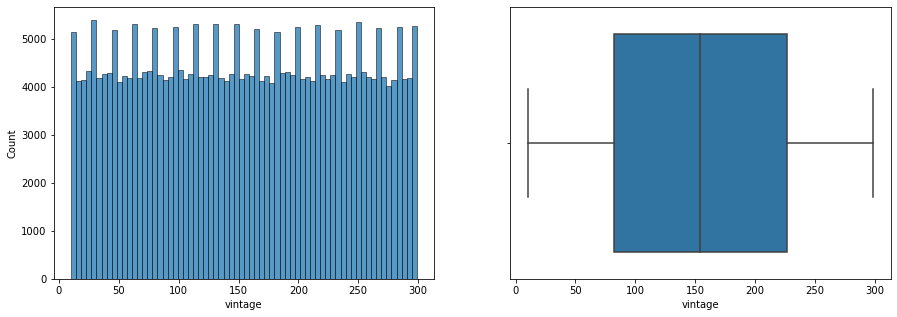

In [159]:
# Vintage 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='vintage')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='vintage')

### 4.1.2 Categorical Features

<Axes: xlabel='driving_license', ylabel='count'>

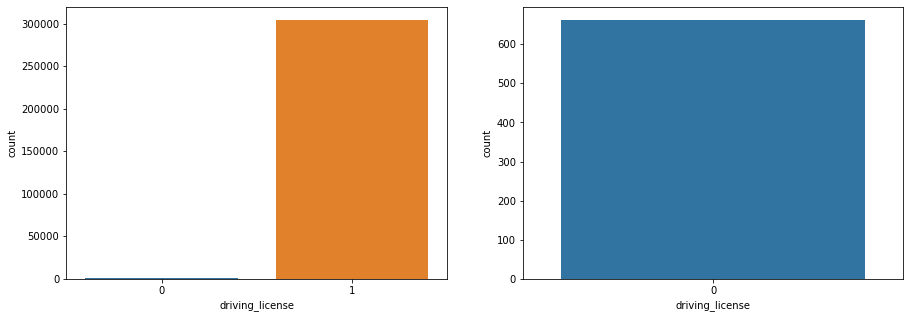

In [160]:
#Driving Licence
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='driving_license')
plt.subplot(1,2,2)
aux = df4.loc[df4['driving_license'] == 0, :].reset_index()
# sns.countplot(data=aux, x='driving_license')
sns.countplot(data=aux, x='driving_license')


<Axes: xlabel='previously_insured', ylabel='count'>

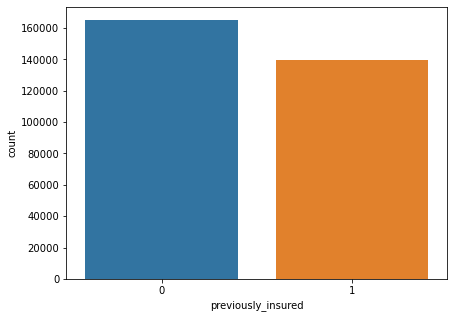

In [161]:
# previously_insured

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='previously_insured')

<Axes: xlabel='gender', ylabel='count'>

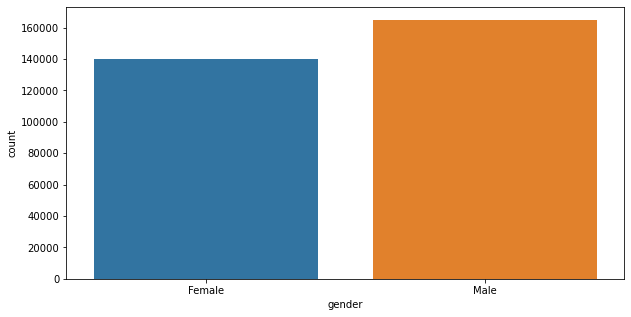

In [162]:
#gender
plt.figure(figsize=(10,5))
sns.countplot(data=df4, x= 'gender') 

<Axes: xlabel='vehicle_age', ylabel='count'>

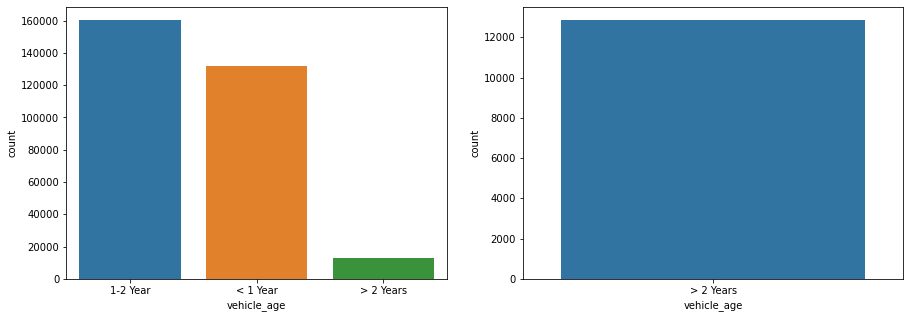

In [163]:
#vehicle_age
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x= 'vehicle_age') 
plt.subplot(1,2,2)
aux = df4.loc[df4['vehicle_age'] == '> 2 Years',:]
sns.countplot(data=aux, x='vehicle_age')

<Axes: xlabel='vehicle_damage', ylabel='count'>

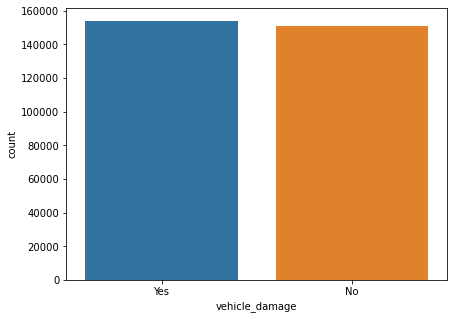

In [164]:
#vehicle_damage
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x= 'vehicle_damage')

<Axes: xlabel='response', ylabel='count'>

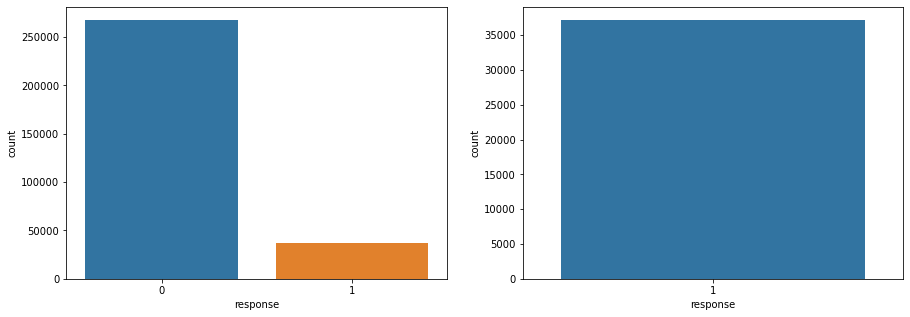

In [165]:
# Response

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='response')
plt.subplot(1,2,2)
aux = df4.loc[df4['response'] == 1, :]
sns.countplot(data=aux, x='response')

<Axes: xlabel='region_code'>

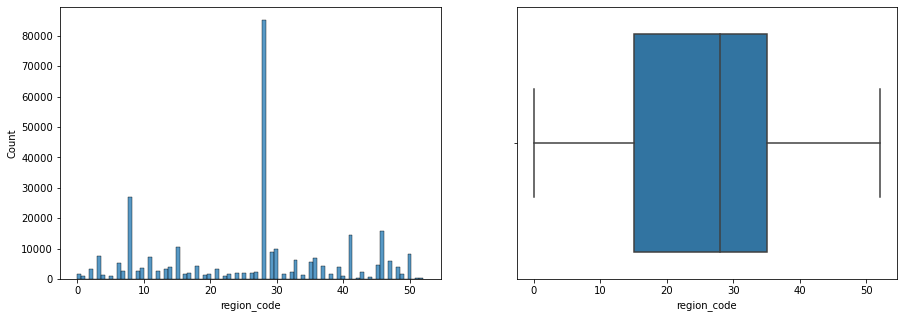

In [166]:
#region_code
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='region_code')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='region_code')

## 5.2 Bivariate Analysis

### H3. Clientes com carros novos com menos de um ano contratariam o seguro veicular
 

<Axes: xlabel='vehicle_age', ylabel='response'>

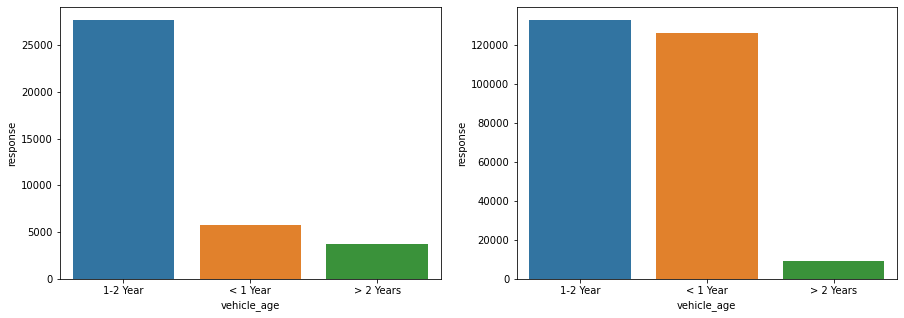

In [167]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
aux = df4.loc[df4['response'] == 1, ['response', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(data=aux, x='vehicle_age', y='response')
plt.subplot(1,2,2)
aux1 = df4.loc[df4['response'] == 0, ['response', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(data=aux1, x='vehicle_age', y='response')


In [168]:
total_response_v = len(df4.loc[df4['response'] == 1,:])
############## Para menos de um ano #################
total_less_oney = len(df4.loc[(df4['response'] == 1) & (df4['vehicle_age'] == '< 1 Year'),:])
percentage_less_oney = total_less_oney/total_response_v
print('Total de pessoas que contratariam o seguro veicular e o carro tem menos de um ano: {:.4f}'.format(percentage_less_oney))

############## Entre um e dois anos #################
total_less_oney = len(df4.loc[(df4['response'] == 1) & (df4['vehicle_age'] == '1-2 Year'),:])
percentage_bwt_onetwo = total_less_oney/total_response_v
print('Total de pessoas que contratariam o seguro veicular e o carro tem entre um e dois anos: {:.4f}'.format(percentage_bwt_onetwo))

Total de pessoas que contratariam o seguro veicular e o carro tem menos de um ano: 0.1544
Total de pessoas que contratariam o seguro veicular e o carro tem entre um e dois anos: 0.7443


Como apenas 15% das pessoas que tem o carro a menos de um ano contratariam o seguro a hipótese **H3** é falsa. Além disso, 74% das pessoas que contratariam o seguro tem o carro entre 1 e 2 anos.

### H4. Pessoas acima dos 30 anos contratariam o seguro veicular


/tmp/ipykernel_23226/2479584926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['age_binned'] = pd.cut(aux['age'], bins)


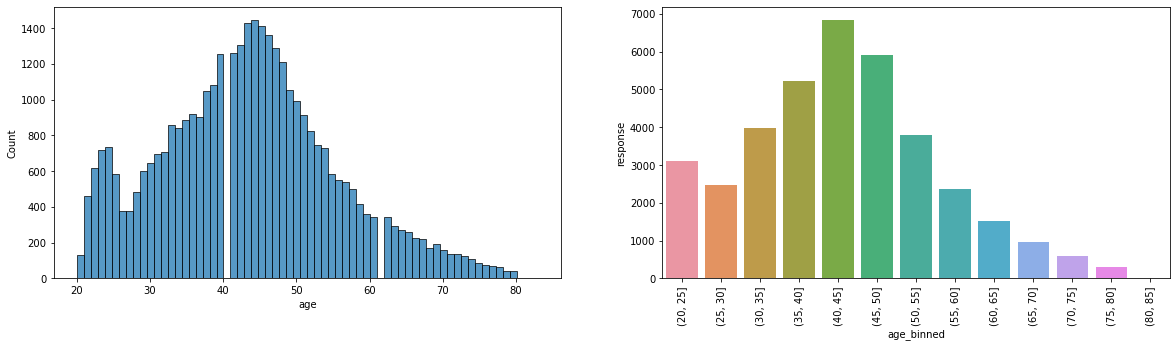

In [169]:
aux = df4.loc[df4['response'] == 1,:]
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.histplot(data=aux, x='age')
plt.subplot(1,2,2)
bins = np.arange(20,90,5)
aux['age_binned'] = pd.cut(aux['age'], bins)
aux2 = aux.loc[:, ['response', 'age_binned']].groupby(['age_binned']).sum().reset_index()
sns.barplot(data=aux2, x='age_binned',y='response')
plt.xticks(rotation=90);

In [170]:
less_30 =len(aux.loc[aux['age'] <30, : ])/len(aux)
higher_30 = len(aux.loc[aux['age'] >30, : ])/len(aux)
print('Total de pessoas que contratariam o seguro e tem mais de 30 anos: {:.4f}'.format(higher_30))
print('Total de pessoas que contratariam o seguro e tem menos de 30 anos: {:.4f}'.format(less_30))


Total de pessoas que contratariam o seguro e tem mais de 30 anos: 0.8459
Total de pessoas que contratariam o seguro e tem menos de 30 anos: 0.1367


Hipótese é **verdadeira**, aproximadamente 85% das pessoas que contratariam o seguro tem mais de 30 anos de idade

### H5. Clientes cujo veículo já sofreu danos contratariam o seguro veicular

In [171]:
df4['vehicle_damage'].value_counts(normalize=True)

vehicle_damage
Yes    0.504899
No     0.495101
Name: proportion, dtype: float64

### H6. Somente clientes habilitados contratariam o seguro veicular


In [172]:
df4['driving_license'].value_counts(normalize=True)

driving_license
1    0.997829
0    0.002171
Name: proportion, dtype: float64

Hipótese verdadeira, 99,7% dos clientes que contratariam o seguro são habilitados.

### H7. Clientes mais antigos da seguradora contratariam o seguro veicular


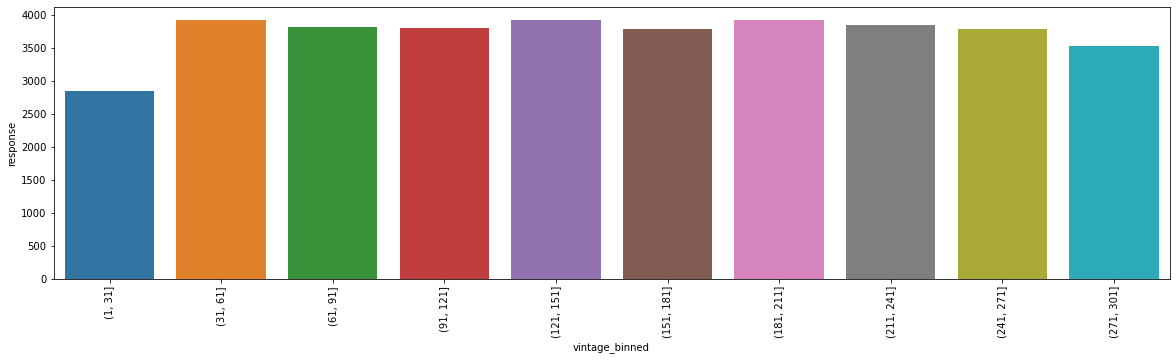

In [173]:
aux = df4.loc[df4['response'] == 1, ['response', 'vintage']]
plt.figure(figsize=(20,5))
bins = np.arange(1,320,30)
aux['vintage_binned'] = pd.cut(aux['vintage'], bins = bins)
aux2 = aux.loc[:, ['response','vintage_binned']].groupby(['vintage_binned']).sum().reset_index()
sns.barplot(data=aux2,x='vintage_binned', y='response')
plt.xticks(rotation=90);


## 5.3 Multivariate Analysis

<Axes: >

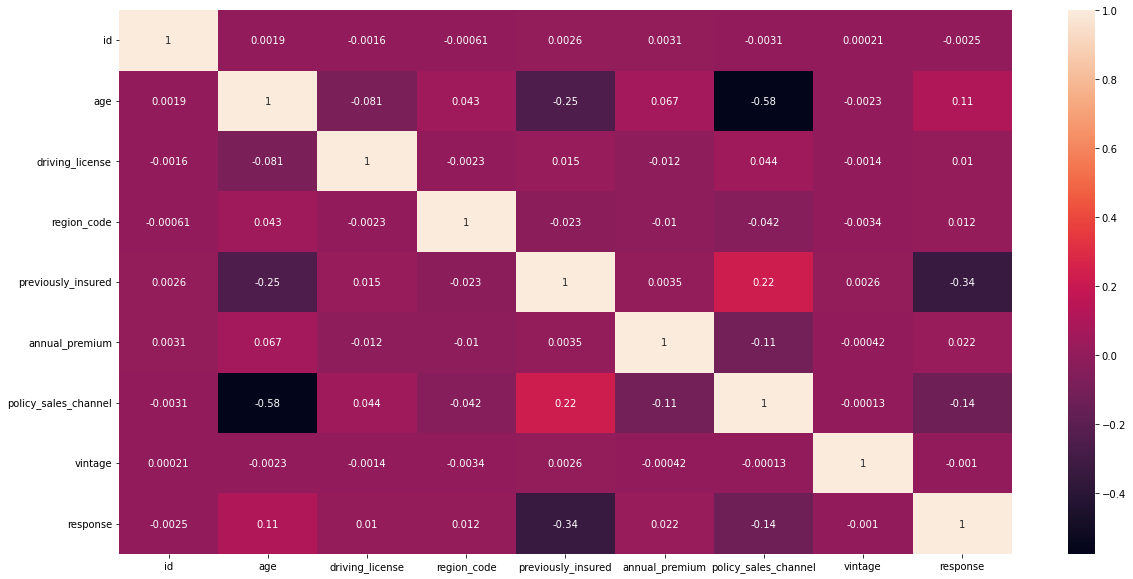

In [174]:

plt.figure(figsize=(20,10))
sns.heatmap(numerical_features.corr('pearson'), annot=True)



# 6.0 Data Preparation

In [254]:
df5 = df46.copy()


In [255]:
df5

,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,gender,vehicle_age,vehicle_damage,response
22193,33,1,28.0,0,46363.0,124.0,114,Female,1-2 Year,Yes,0
150347,64,1,11.0,1,39612.0,26.0,28,Male,1-2 Year,No,0
69197,78,1,28.0,0,59054.0,122.0,195,Female,> 2 Years,Yes,0
372839,26,1,10.0,1,28673.0,152.0,224,Female,< 1 Year,No,0
140927,27,1,28.0,1,50908.0,152.0,252,Female,< 1 Year,No,0
...,...,...,...,...,...,...,...,...,...,...,...
347449,46,1,21.0,0,33012.0,26.0,232,Male,1-2 Year,Yes,1
321879,52,1,50.0,0,26838.0,124.0,103,Male,1-2 Year,Yes,1
64820,30,1,30.0,0,26651.0,154.0,50,Male,< 1 Year,Yes,1
175203,43,1,28.0,0,28991.0,26.0,121,Male,1-2 Year,Yes,1


### 6.1 Encodind

In [256]:

le_vehicle_age = pp.LabelEncoder()

#gender train
df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender']  ,dtype='int64')

#gender test
df_test = pd.get_dummies(df_test, prefix=['gender'], columns=['gender'], dtype='int64' )

#vehicle_age train
df5['vehicle_age'] = le_vehicle_age.fit_transform(df5[['vehicle_age']].values)
pickle.dump(le_vehicle_age, open('../parameters/vehicle_age_encoding.pkl','wb'))

#vehicle_age test
df_test['vehicle_age'] = le_vehicle_age.transform(df_test[['vehicle_age']].values)

#vehicle_damage train
df5 = pd.get_dummies(df5, prefix=['vehicle_damage'], columns=['vehicle_damage'] ,dtype='int64' )

#vehicle_damage test
df_test = pd.get_dummies(df_test, prefix=['vehicle_damage'], columns=['vehicle_damage'], dtype='int64'  )




/home/alexandrerod/anaconda3/envs/HealthInsurance/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alexandrerod/anaconda3/envs/HealthInsurance/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### 6.3 Rescaling

In [177]:
# rs_annual = pp.RobustScaler()
# rs_vintage = pp.RobustScaler()

# mms_age= pp.MinMaxScaler()
# mms_region = pp.MinMaxScaler()
# mms_policy = pp.MinMaxScaler()

# #age train
# df5['age'] = mms_age.fit_transform(df5[['age']].values)
# pickle.dump(mms_age,open('../parameters/age_scaler.pkl', 'wb'))
# #age test
# df_test['age'] = mms_age.transform(df_test[['age']].values)

# #region_code train
# df5['region_code'] = mms_region.fit_transform(df5[['region_code']].values)
# pickle.dump(mms_region, open('../parameters/region_scaler.pkl', 'wb'))
# #region_code test
# df_test['region_code'] = mms_region.transform(df_test[['region_code']].values)

# #annual_premium train
# df5['annual_premium'] = rs_annual.fit_transform(df5[['annual_premium']].values)
# pickle.dump(rs_annual, open('../parameters/annual_premium.pkl', 'wb'))

# #annual_premium test
# df_test['annual_premium'] = rs_annual.transform(df_test[['annual_premium']].values)

# #policy_sales_channel train
# df5['policy_sales_channel'] = mms_policy.fit_transform(df5[['policy_sales_channel']].values)
# pickle.dump(mms_policy, open('../parameters/policy_chanel_scaler.pkl', 'wb'))

# #policy_sales_channel test
# df_test['policy_sales_channel'] = mms_policy.transform(df_test[['policy_sales_channel']].values)

# #vintage train
# df5['vintage'] = rs_vintage.fit_transform(df5[['vintage']].values)
# pickle.dump(rs_vintage, open('../parameters/vintage_scaler.pkl', 'wb'))
# #vintage test
# df_test['vintage'] = rs_vintage.transform(df_test[['vintage']].values)


# 7.0 Feature Selection

In [178]:
X_train = df5.drop('response', axis=1)
y_train = df5['response']

X_val = df_test.drop('response', axis=1)
y_val = df_test['response']

print('Number of rows in x_train: {}'.format(len(X_train)))
print('Number of rows in x_val: {}'.format(len(X_val)))
print('Number of rows in y_train: {}'.format(len(y_train)))
print('Number of rows in y_val: {}'.format(len(y_val)))


Number of rows in x_train: 74374
Number of rows in x_val: 76222
Number of rows in y_train: 74374
Number of rows in y_val: 76222


## 7.1 Boruta as Feat Selector

In [179]:
# X_train_n = X_train.values
# y_train_n = y_train.ravel()

# rf= en.RandomForestClassifier(n_jobs=-1)

### 7.2.1 Features Select from boruta

In [180]:
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# boruta.fit(X_train_n, y_train_n)

In [181]:
# cols_selected = boruta.support_.tolist()
# cols_selected
# X_train_fs = X_train
# cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.tolist()
# cols_selected_boruta


### 7.1.2 Manual Feature Selection

In [182]:
cols_selected_boruta = ['age', 'previously_insured', 'vehicle_damage_No', 'vehicle_damage_Yes']


## 7.2 Feature Importance

In [183]:
#model define
rf_select = en.RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

rf_select.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [184]:
importances = rf_select.feature_importances_

In [185]:
for feature, importance in zip(X_train,importances):
    print(feature, importance)

age 0.1324875526254175
driving_license 0.0006382068333260533
region_code 0.08799879710969162
previously_insured 0.10527267971468543
annual_premium 0.16035303642829743
policy_sales_channel 0.06585192841594212
vintage 0.18052787475070847
vehicle_age 0.015160909014734842
gender_Female 0.003019268668836309
gender_Male 0.0030759119472434904
vehicle_damage_No 0.13460312888735937
vehicle_damage_Yes 0.11101070560375752


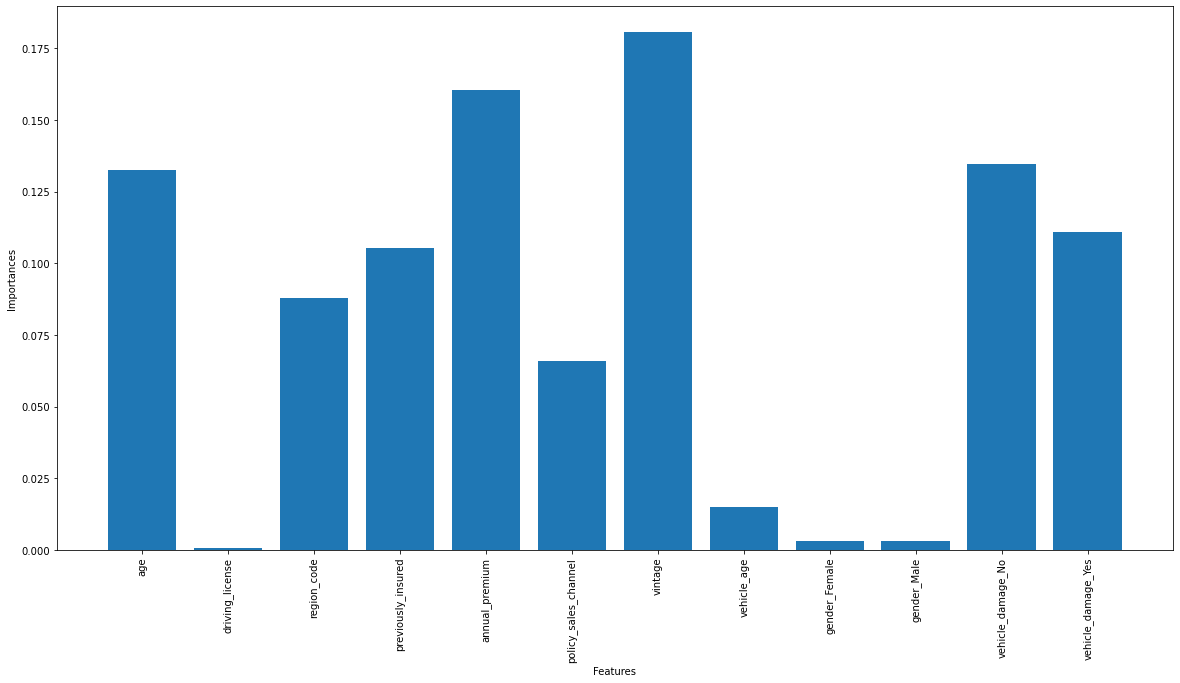

In [186]:
plt.figure(figsize=(20,10))
plt.bar(X_train.columns, importances)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation=90);

<BarContainer object of 12 artists>

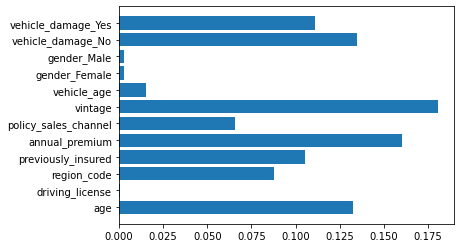

In [187]:
plt.barh(X_train.columns, importances)

In [188]:
cols_selected_rf = ['age','vintage', 'annual_premium']

# 8.0 Machine Learning Modelling

In [189]:
x_train = X_train[cols_selected_boruta]
x_val = X_val[cols_selected_boruta]

# x_train = X_train[cols_selected_rf]
# x_test = X_test[cols_selected_rf]



## 8.1 KNN

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

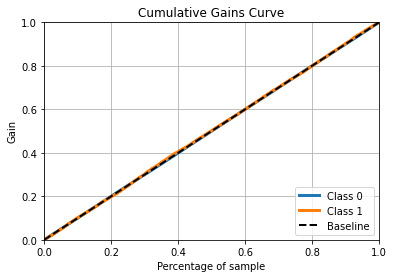

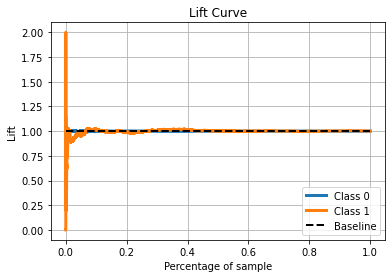

In [190]:
#model
knn = ng.KNeighborsClassifier(n_neighbors=8)

#model training
knn.fit(x_train, y_train)

#predict

yhat_knn = knn.predict_proba(x_val)

#performance
result_knn  = model_result('Knn', x_val, y_val, yhat_knn ,2000)
result_knn

sktplt.metrics.plot_cumulative_gain(y_val, yhat_knn)
sktplt.metrics.plot_lift_curve(y_val,yhat_knn)

#### 8.1.1 KNN - CROSS VALIDATION

In [191]:
knn_cv = cross_validation('KNN CV', knn, x_train,y_train, kfold=8)
knn_cv

,Model name,Precision at k,Recall at k
0,KNN CV,0.993 +/- 0.0027,0.4275 +/- 0.0012


## 8.2 Decision Three

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

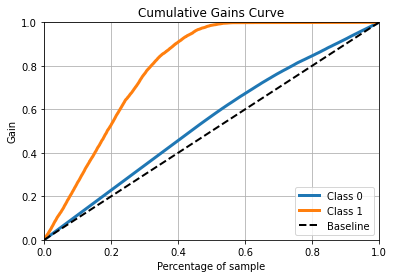

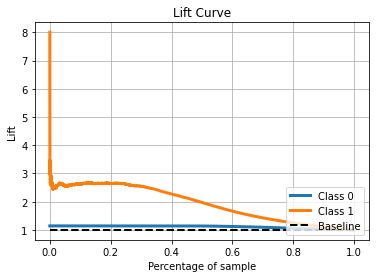

In [192]:
#model
model_tr = tr.DecisionTreeClassifier(max_depth=5, random_state=42)
#model training
model_tr.fit(x_train, y_train)
#model predict
yhat_tr = model_tr.predict_proba(x_val)
#performance

result_tr = model_result('Decision Tree', x_val, y_val,yhat_tr, 2000)

sktplt.metrics.plot_cumulative_gain(y_val, yhat_tr)
sktplt.metrics.plot_lift_curve(y_val, yhat_tr)

#### 8.2.1 Decision Tree Cross Validation

In [193]:
tr_cv = cross_validation('Decision Tree CV', model_tr, x_train, y_train, kfold=8)
tr_cv

,Model name,Precision at k,Recall at k
0,Decision Tree CV,0.8291 +/- 0.0455,0.3569 +/- 0.0196


## 8.3 Random Forest

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

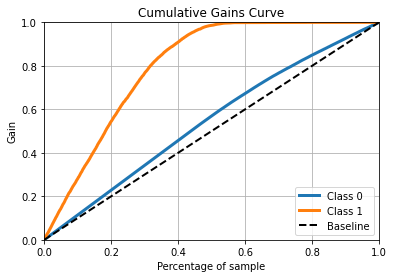

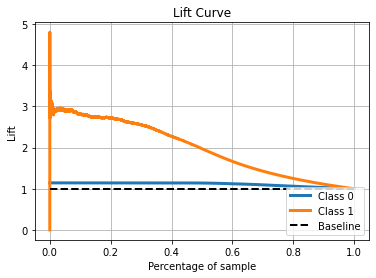

In [194]:
#model definition
 
rf= en.RandomForestClassifier(n_estimators= 1000,max_depth=5, n_jobs=-1, random_state=42)
#model training
rf.fit(x_train, y_train)
#model predict
yhat_rf = rf.predict_proba(x_val)
#model performance
result_rf = model_result('Random Forest', x_val,y_val,yhat= yhat_rf,k=2000)
result_rf

sktplt.metrics.plot_cumulative_gain(y_val, yhat_rf)
sktplt.metrics.plot_lift_curve(y_val, yhat_rf)

#### 8.3.1 Random Forest Cross Validation

In [195]:
rf_cv = cross_validation('Random Forest CV', rf, x_train, y_train, kfold=8)
rf_cv

,Model name,Precision at k,Recall at k
0,Random Forest CV,0.7784 +/- 0.0114,0.3351 +/- 0.0049


## 8.4 XBG

In [196]:
#model
xgb_model = xgb.XGBClassifier(n_estimators= 1000,max_depth=5, n_jobs=-1, random_state=42)
#model training
xgb_model.fit(x_train, y_train)
#model predict
yhat_xgb = xgb_model.predict_proba(x_val)
#model performance
result_xgb = model_result('XGB', x_val, y_val, yhat_xgb, k=2000)
result_xgb

# sktplt.metrics.plot_cumulative_gain(y_test, yhat_xgb),
# sktplt.metrics.plot_lift_curve(y_test, yhat_xgb)

,Model name,Precision at k,Recall at k
0,XGB,0.383808,0.080647


### 8.4.1 XGB Cross Validation

In [197]:
xgb_cv = cross_validation('XGB CV', xgb_model, x_train, y_train, kfold=8)
xgb_cv

,Model name,Precision at k,Recall at k
0,XGB CV,0.7798 +/- 0.0055,0.3357 +/- 0.0024


## 8.5 Compare model performance


### 8.5.1 Single Performance

In [198]:
final_performance = pd.concat([result_knn, result_tr, result_rf, result_xgb])
final_performance.reset_index(drop=True)

,Model name,Precision at k,Recall at k
0,Knn,0.108446,0.022787
1,Decision Tree,0.318841,0.066996
2,Random Forest,0.356322,0.074871
3,XGB,0.383808,0.080647


### 8.5.2 Cross Validation Performance

In [199]:
performance_cv= pd.concat([knn_cv,tr_cv, rf_cv,xgb_cv])
performance_cv.reset_index(drop=True)

,Model name,Precision at k,Recall at k
0,KNN CV,0.993 +/- 0.0027,0.4275 +/- 0.0012
1,Decision Tree CV,0.8291 +/- 0.0455,0.3569 +/- 0.0196
2,Random Forest CV,0.7784 +/- 0.0114,0.3351 +/- 0.0049
3,XGB CV,0.7798 +/- 0.0055,0.3357 +/- 0.0024


# 9.0 Hyperparameter Fine Tuning

## 9.1 Random Search

In [200]:
params = {
    'n_estimators' : [100,200,300,400],
    'max_depth': [3,5,8,12],
    'subsample': [0.8,0.85,0.9,1],
    'colsample_bytree': [0.3,0.5,0.7,1],
    }

MAX_EVAL = 10



In [201]:
result_tunning_cv = pd.DataFrame()

In [202]:
# #model
# for i in range(MAX_EVAL):
#     hp = {k: random.sample(v,1)[0] for k,v in params.items()}
#     print(hp)
#     xgb_model_tunning_cv = xgb.XGBClassifier(n_estimators = hp['n_estimators'],
#                                         max_depth = hp['max_depth'],
#                                         subsample = hp['subsample'],
#                                         colsample_bytree = hp['colsample_bytree']                                   
#                                         )
    
#     result_cv = cross_validation('XGB Tunning CV', xgb_model_tunning_cv, x_train, y_train, kfold=8)
#     result_tunning_cv = pd.concat([result_tunning_cv, result_cv])

In [203]:
# result_tunning_cv

## 9.2 Final Model

In [204]:
# param_tunned = {'n_estimators': 1500, 'max_depth': 3, 'subsample': 1, 'colsample_bytree': 0.7}
# # param_tunned = {'n_estimators': 1500, 'max_depth': 3, 'subsample': 1, 'colsample_bytree': 0.3}
# param_tunned = {'n_estimators': 2000, 'max_depth': 12, 'subsample': 0.85, 'colsample_bytree': 0.7}
param_tunned = {'n_estimators': 200, 'max_depth': 3, 'subsample': 0.85, 'colsample_bytree': 0.3}






In [205]:
xgb_tunned = xgb.XGBClassifier(n_estimators = param_tunned['n_estimators'],
                                        max_depth = param_tunned['max_depth'],
                                        subsample = param_tunned['subsample'],
                                        colsample_bytree = param_tunned['colsample_bytree']                                   
                                        )
#model training
xgb_tunned.fit(x_train, y_train)
#model predict
yhat_xgb_tunned = xgb_tunned.predict_proba(x_val)
#model performance
result_tunned = model_result('XGB Tunned', x_val, y_test, yhat_xgb_tunned, k=2000)

In [206]:
result_tunned


,Model name,Precision at k,Recall at k
0,XGB Tunned,0.386307,0.081172


# 10.0 Understanding Metrics

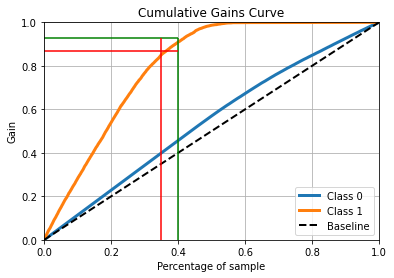

In [207]:
sktplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_tunned)
plt.hlines(0.93,xmin=0, xmax=0.40, colors='green')
plt.vlines(0.4, ymin=0, ymax=0.93, colors='green')

plt.hlines(0.87,xmin=0, xmax=0.40, colors='red')
plt.vlines(0.35, ymin=0, ymax=0.93, colors='red')

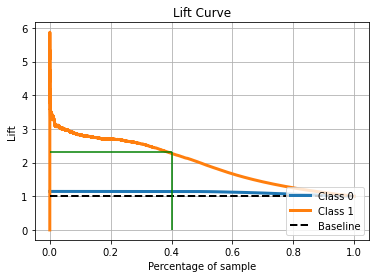

In [208]:
sktplt.metrics.plot_lift_curve(y_val, yhat_xgb_tunned)
plt.hlines(2.3,xmin=0, xmax=0.4, colors='green')
plt.vlines(0.4, ymin=0, ymax=2.3, colors='green')

# 11.0 DEPLOY MODEL TO PRODUCTION


In [218]:
#save trained model
pickle.dump(xgb_tunned, open('/home/alexandrerod/Documentos/repos/health_insurance_cross_sell/models/xgb_tunned.pkl','wb'))


## 11.1 Heath Insurance Class

In [281]:
class HealthInsurance:
    def __init__(self):
        self.home_path = '/home/alexandrerod/Documentos/repos/health_insurance_cross_sell/'
        self.age_scaler = pickle.load(open(self.home_path + 'parameters/age_scaler.pkl','rb'))
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'parameters/annual_premium.pkl','rb'))
        self.policy_chanel_scaler = pickle.load(open(self.home_path + 'parameters/policy_chanel_scaler.pkl','rb'))
        self.region_scaler = pickle.load(open(self.home_path + 'parameters/region_scaler.pkl','rb'))
        self.vintage_scaler = pickle.load(open(self.home_path + 'parameters/vintage_scaler.pkl','rb'))
        self.vehicle_age_encoding = pickle.load(open(self.home_path + 'parameters/vehicle_age_encoding.pkl','rb'))

    def cleanind_data (self, df1):

        #old columns
        cols_old = list(df1.columns)
        #creating function
        rename_columns = lambda x: inflection.underscore(x)
        #new columns
        cols_new = list(map(rename_columns, cols_old))
        #renaming columns 
        df1.columns = cols_new

        return df1
    
    def feature_engineering (self, df2):
        return df2
    
    def data_preparation(self, df5):

       
        #gender train
        df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender']  ,dtype='int64')
        
        
        #vehicle_age train
        df5['vehicle_age'] = self.vehicle_age_encoding.transform(df5[['vehicle_age']].values)

    
        #vehicle_damage train
        df5 = pd.get_dummies(df5, prefix=['vehicle_damage'], columns=['vehicle_damage'] ,dtype='int64' )
        
    
        cols_selected = ['age', 'previously_insured', 'vehicle_damage_No', 'vehicle_damage_Yes']
        
                            
        return df5[cols_selected]
    
    def get_prediction (self, model, original_data, test_data):
        #model prediciton
        pred = model.predict_proba(test_data)
        #join prediciton in original data
        original_data['prediction'] = pred[:,1]
        
        return original_data.to_json(orient='records', date_format = 'ISO')


## 11.2 API Handler

In [274]:
#load model 

path = '/home/alexandrerod/Documentos/repos/health_insurance_cross_sell/'
model = pickle.load(open(path + 'models/xgb_tunned.pkl', 'rb'))

#start api
app = Flask(__name__)

@app.route('/predict', methods=['POST'])

def health_insurance_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json,dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        #start class
        pipeline = HealthInsurance()

        #cleaning
        df1 = pipeline.cleanind_data(test_raw)

        #feature engineering
        df2 = pipeline.feature_engineering(df1)

        #data preparation
        df3 = pipeline.data_preparation(df2)

        #predict
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    else:
        return Response({}, status=200, mimetype='application/json')


if __name__ == "__main__":
    app.run('127.0.0.1')
    

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


AttributeError: 'tuple' object has no attribute 'tb_frame'

## 11.3 API Tester

In [310]:
df_test = pd.read_csv('../inputs/test.csv')
df_test['response'] = y_test


In [311]:
df_test = df_test.sample(10)

In [312]:
df_test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,response
95084,476194,Male,24,1,15.0,1,< 1 Year,No,2630.0,152.0,152,NaN
91026,472136,Female,35,1,3.0,0,1-2 Year,Yes,26102.0,26.0,110,0.0
87726,468836,Male,22,1,46.0,0,< 1 Year,No,2630.0,152.0,77,NaN
115653,496763,Female,35,1,35.0,0,1-2 Year,Yes,52918.0,154.0,164,NaN
14438,395548,Female,24,1,28.0,0,< 1 Year,Yes,44929.0,122.0,221,0.0
72534,453644,Female,37,1,14.0,1,1-2 Year,No,35151.0,152.0,157,NaN
20603,401713,Male,22,1,33.0,0,< 1 Year,Yes,17578.0,152.0,277,NaN
35096,416206,Female,25,1,36.0,0,< 1 Year,No,26916.0,152.0,57,NaN
48617,429727,Male,60,1,43.0,0,1-2 Year,Yes,2630.0,157.0,46,NaN
50863,431973,Male,75,1,28.0,1,1-2 Year,Yes,71647.0,26.0,55,NaN


In [313]:
#convert dataframe to json

data = json.dumps(df_test.to_dict(orient='records'))
data

'[{"id": 476194, "Gender": "Male", "Age": 24, "Driving_License": 1, "Region_Code": 15.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 2630.0, "Policy_Sales_Channel": 152.0, "Vintage": 152, "response": NaN}, {"id": 472136, "Gender": "Female", "Age": 35, "Driving_License": 1, "Region_Code": 3.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 26102.0, "Policy_Sales_Channel": 26.0, "Vintage": 110, "response": 0.0}, {"id": 468836, "Gender": "Male", "Age": 22, "Driving_License": 1, "Region_Code": 46.0, "Previously_Insured": 0, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 2630.0, "Policy_Sales_Channel": 152.0, "Vintage": 77, "response": NaN}, {"id": 496763, "Gender": "Female", "Age": 35, "Driving_License": 1, "Region_Code": 35.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 52918.0, "Policy_Sales_Channel": 154.0, "Vintage": 

In [314]:
# API Call
url = 'http://127.0.0.1:5000/predict'
#url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [300]:
r

<Response [200]>

In [315]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('prediction', ascending=False).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction
1,472136,Female,35,1,3.0,0,1-2 Year,Yes,26102.0,26.0,110,0.0,0.808383
3,496763,Female,35,1,35.0,0,1-2 Year,Yes,52918.0,154.0,164,NaN,0.808383
8,429727,Male,60,1,43.0,0,1-2 Year,Yes,2630.0,157.0,46,NaN,0.615595
4,395548,Female,24,1,28.0,0,< 1 Year,Yes,44929.0,122.0,221,0.0,0.552961
6,401713,Male,22,1,33.0,0,< 1 Year,Yes,17578.0,152.0,277,NaN,0.499482
